# Tasks with Deep Autoencoders 


Autoencoders are neural networks that aim to copy their inputs to their outputs. They work by compressing the input into a latent-space representation, and then reconstructing the output from this representation. This kind of network is composed of two parts:
+ Encoder: the part of the network that compresses the input into a latent-space representation. It can be represented by an encoding function h=f(x).
+ Decoder: this part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function r=g(h).

This notebook will involve training deep autoencoders and applying them to faces and similar images search.

The new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

This project has been adapted from Coursera's Advanced Machine Learning course.

In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import tqdm
from collections import defaultdict
from keras.models import save_model
import os
import cv2
import tarfile

Using TensorFlow backend.


## Helper Functions

In [2]:
ATTRS_NAME = "lfw_attributes.txt" 
IMAGES_NAME = "lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "lfw.tgz"

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    #read attributes
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs.columns = list(df_attrs.columns)[1:] + ["NaN"]
    df_attrs = df_attrs.drop("NaN", axis=1)
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    #read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                #prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                #parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    #preserve photo_id order
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

def use_simple_tqdm():
    try:
        import google.colab
        import os
        return not bool(int(os.environ.get("EXPERIMENTAL_TQDM", "0")))
    except ImportError:
        return False

def tqdm_notebook_failsafe(*args, **kwargs):
    if use_simple_tqdm():
        return SimpleTqdm(*args, **kwargs)
    else:
        return tqdm.tqdm_notebook(*args, **kwargs)

In [3]:
class TqdmProgressCallback(keras.callbacks.Callback):

    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        print('\nEpoch %d/%d' % (epoch + 1, self.epochs))
        if "steps" in self.params:
            self.use_steps = True
            self.target = self.params['steps']
        else:
            self.use_steps = False
            self.target = self.params['samples']
        self.prog_bar = tqdm_notebook_failsafe(total=self.target)
        self.log_values_by_metric = defaultdict(list)

    def _set_prog_bar_desc(self, logs):
        for k in self.params['metrics']:
            if k in logs:
                self.log_values_by_metric[k].append(logs[k])
        desc = "; ".join("{0}: {1:.4f}".format(k, np.mean(values)) for k, values in self.log_values_by_metric.items())
        if hasattr(self.prog_bar, "set_description_str"):  # for new tqdm versions
            self.prog_bar.set_description_str(desc)
        else:
            self.prog_bar.set_description(desc)

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        if self.use_steps:
            self.prog_bar.update(1)
        else:
            batch_size = logs.get('size', 0)
            self.prog_bar.update(batch_size)
        self._set_prog_bar_desc(logs)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self._set_prog_bar_desc(logs)
        self.prog_bar.update(1)  #workaround to show description
        self.prog_bar.close()


class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

## Load dataset
Links to the data for download are as follows:
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [4]:
#load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

#centre images
X = X.astype('float32') / 255.0 - 0.5

#train-test split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [5]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
Attribute shape: (13143, 73)


20384

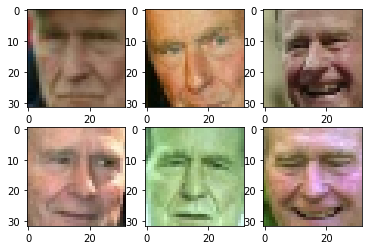

In [6]:
plt.title('Sample Images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("Attribute shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

## Autoencoder architecture

The autoencoder will be designed as two sequential keras models: the encoder and decoder respectively. Symbolic API will then be used to apply and train these models.

In the following:
1. PCA (dimensionality reduction)
2. Convolutional autoencoder
3. Deionising autoencoder
4. Image retrieval with autoencoders
5. Cheap image morphing

### 1. PCA

Principal Component Analysis (PCA) is a dimensionality reduction method. It attempts to decompose object-feature matrix into two smaller matrices, minimising _mean squared error_:

PCA can also be seen as a special case of an autoencoder.
* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton.

In [7]:
#function to define a simple linear autoencoder, 
#and to flatten and un-flatten data to be compatible with image shapes
def build_pca_autoencoder(img_shape, code_size):
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())  #flatten image to vector
    encoder.add(L.Dense(code_size)) #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape)) #un-flatten
    
    return encoder,decoder

In [8]:
s = tf.keras.backend.clear_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[TqdmProgressCallback()],
                verbose=0)


Epoch 1/15


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch 2/15




Epoch 3/15




Epoch 4/15




Epoch 5/15




Epoch 6/15




Epoch 7/15




Epoch 8/15




Epoch 9/15




Epoch 10/15




Epoch 11/15




Epoch 12/15




Epoch 13/15




Epoch 14/15




Epoch 15/15


In [9]:
#function to draw original, encoded and decoded images
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

PCA MSE: 0.006594267339859965


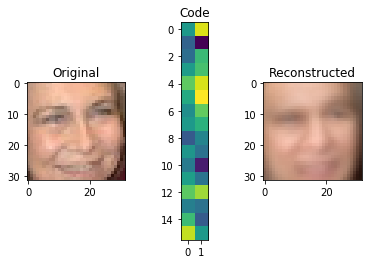

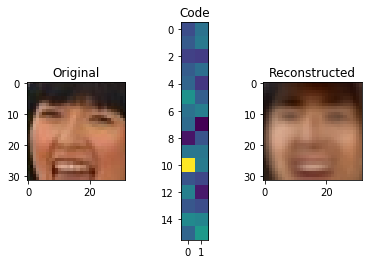

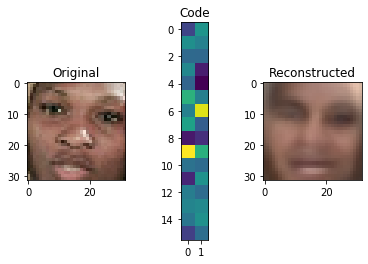

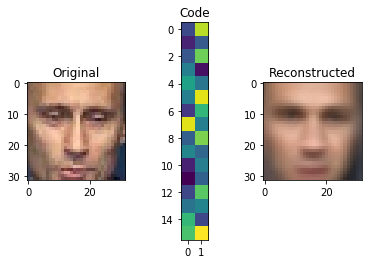

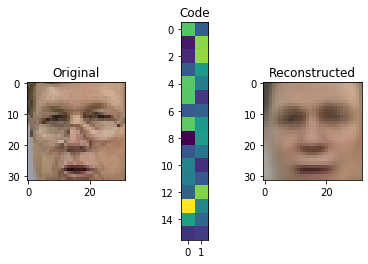

In [10]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

## 2. Convolutional autoencoder

Now, a deep convolutional autoencoder will be built by stacking more layers.

The **encoder** part involves stacking convolutional and pooling layers and finishing with a dense layer to get the representation of desirable size (`code_size`). `activation='elu'` will be used for all convolutional and dense layers. For this example, (conv, pool) will be repearted 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`. Output will be flattened (`L.Flatten()`) before adding the last dense layer.

For the **decoder**, "transpose convolution" will be used. Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution"  a number is taken and a patch of an image (number -> patch) produced. This layer is needed to "undo" convolutions in encoder.

Here's how "transpose convolution" works:
<img src="images/transpose_conv.jpg" style="width:60%">
In the above example, a stride of 2 is used to produce 4x4 output, "undoing" pooling as well. 

In [11]:
#function to build deep autoencoder
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    #encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    #define encoder
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))

    #decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    #define decoder
    decoder.add(L.Dense(2*2*256))
    #reshape to undo flatten
    decoder.add(L.Reshape((2, 2, 256)))
    #transpose convolution layers
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [12]:
#check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = tf.keras.backend.clear_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = tf.keras.backend.clear_session()

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [13]:
#view encoder and decoder shapes
s = tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [14]:
s = tf.keras.backend.clear_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [15]:
#save model checkpoints to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = tf.keras.backend.clear_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [16]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[ModelSaveCallback(model_filename),
                           TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)


Epoch 1/25


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Model saved in autoencoder.000.hdf5


Epoch 2/25


Model saved in autoencoder.001.hdf5


Epoch 3/25


Model saved in autoencoder.002.hdf5


Epoch 4/25


Model saved in autoencoder.003.hdf5


Epoch 5/25


Model saved in autoencoder.004.hdf5


Epoch 6/25


Model saved in autoencoder.005.hdf5


Epoch 7/25


Model saved in autoencoder.006.hdf5


Epoch 8/25


Model saved in autoencoder.007.hdf5


Epoch 9/25


Model saved in autoencoder.008.hdf5


Epoch 10/25


Model saved in autoencoder.009.hdf5


Epoch 11/25


Model saved in autoencoder.010.hdf5


Epoch 12/25


Model saved in autoencoder.011.hdf5


Epoch 13/25


Model saved in autoencoder.012.hdf5


Epoch 14/25


Model saved in autoencoder.013.hdf5


Epoch 15/25


Model saved in autoencoder.014.hdf5


Epoch 16/25


Model saved in autoencoder.015.hdf5


Epoch 17/25


Model saved in autoencoder.016.hdf5


Epoch 18/25


Model saved in autoencoder.017.hdf5


Epoch 19/25


Model saved in autoencoder.018.hdf5


Epoch 20/25


Model saved in autoencoder.019.hdf5


Epoch 21/25


Model saved in autoencoder.020.hdf5


Epoch 22/25


Model saved in autoencoder.021.hdf5


Epoch 23/25


Model saved in autoencoder.022.hdf5


Epoch 24/25


Model saved in autoencoder.023.hdf5


Epoch 25/25


Model saved in autoencoder.024.hdf5



Convolutional autoencoder MSE: 0.005485670763411393


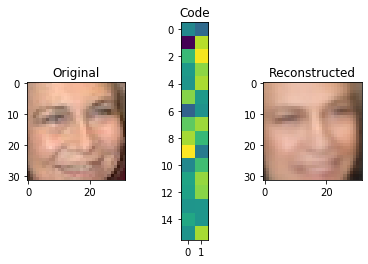

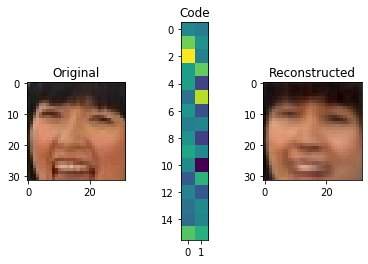

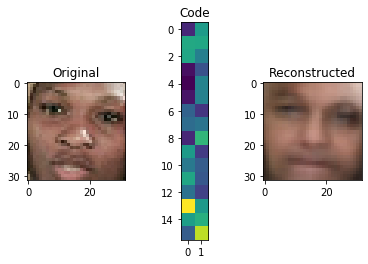

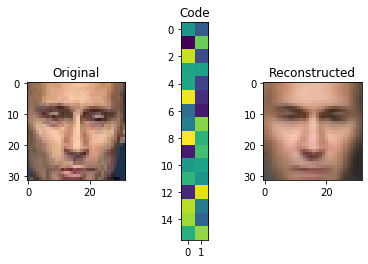

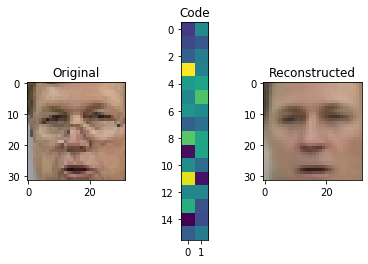

In [17]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [18]:
#save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [19]:
#restore trained weights
s = tf.keras.backend.clear_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.005485670763411393
0.005485670763411393


## 3. Denoising Autoencoder

One useful application of autoencoders is denoising. 

<img src="images/denoising.jpg" style="width:40%">

The model architecture is kept, but the way it is trained is changed, in particular, by corrupting its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. Here, gaussian white noise will be added.

In [20]:
#function to add noise from standard normal distribution with standard deviation sigma
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

In [21]:
#noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

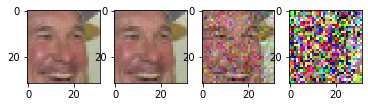

In [22]:
#test different noise scales on image
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

In [24]:
s = tf.keras.backend.clear_session()

#use bigger code size for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    #continue to train model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...

Epoch 1/1


/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2/25, Generating corrupted samples...

Epoch 1/1



Epoch 3/25, Generating corrupted samples...

Epoch 1/1



Epoch 4/25, Generating corrupted samples...

Epoch 1/1



Epoch 5/25, Generating corrupted samples...

Epoch 1/1



Epoch 6/25, Generating corrupted samples...

Epoch 1/1



Epoch 7/25, Generating corrupted samples...

Epoch 1/1



Epoch 8/25, Generating corrupted samples...

Epoch 1/1



Epoch 9/25, Generating corrupted samples...

Epoch 1/1



Epoch 10/25, Generating corrupted samples...

Epoch 1/1



Epoch 11/25, Generating corrupted samples...

Epoch 1/1



Epoch 12/25, Generating corrupted samples...

Epoch 1/1



Epoch 13/25, Generating corrupted samples...

Epoch 1/1



Epoch 14/25, Generating corrupted samples...

Epoch 1/1



Epoch 15/25, Generating corrupted samples...

Epoch 1/1



Epoch 16/25, Generating corrupted samples...

Epoch 1/1



Epoch 17/25, Generating corrupted samples...

Epoch 1/1



Epoch 18/25, Generating corrupted samples...

Epoch 1/1



Epoch 19/25, Generating corrupted samples...

Epoch 1/1



Epoch 20/25, Generating corrupted samples...

Epoch 1/1



Epoch 21/25, Generating corrupted samples...

Epoch 1/1



Epoch 22/25, Generating corrupted samples...

Epoch 1/1



Epoch 23/25, Generating corrupted samples...

Epoch 1/1



Epoch 24/25, Generating corrupted samples...

Epoch 1/1



Epoch 25/25, Generating corrupted samples...

Epoch 1/1


Denoising MSE: 0.0027721743722633942


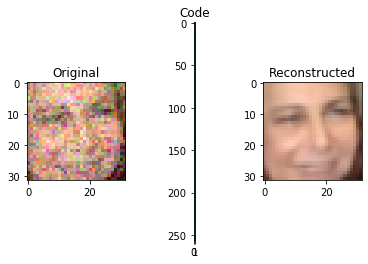

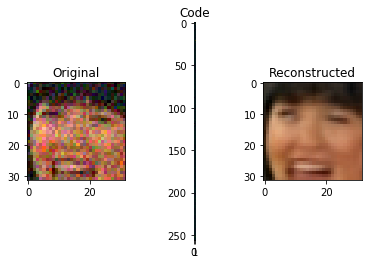

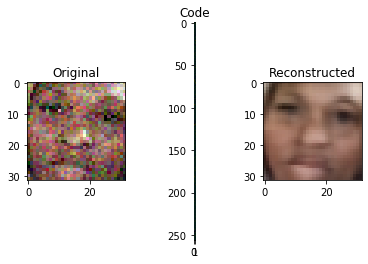

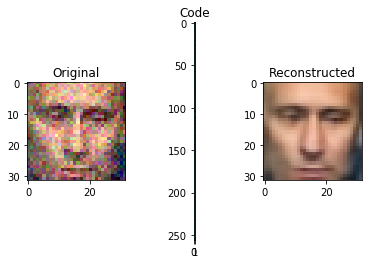

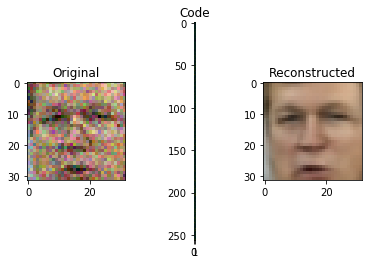

In [25]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img, encoder, decoder)

## 4. Image retrieval with autoencoders

First is image retrieval, aka image search. The autoencoder is given an image and it finds similar images in latent space.

To speed up retrieval process, Locality Sensitive Hashing should be used on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of an image in latent space (encoder code). Nearest neighbours can then be calculated in a brute force way for simplicity.

In [26]:
#restore trained encoder weights
s = tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [27]:
images = X_train
codes = encoder.predict(images) #encode all images
assert len(codes) == len(images)

In [28]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

/Users/charlottefettes/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [29]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,), (idx,) = nei_clf.kneighbors(code, n_neighbors=n_neighbors)
    
    return distances, images[idx]

In [30]:
def show_similar(image):
    
    distances, neighbors = get_similar(image, n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Examples:

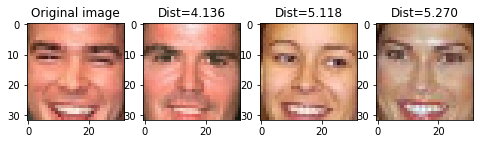

In [31]:
show_similar(X_test[247])

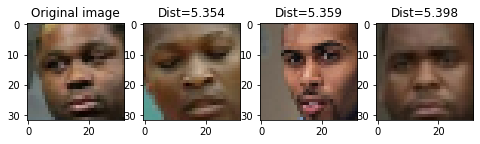

In [32]:
show_similar(X_test[56])

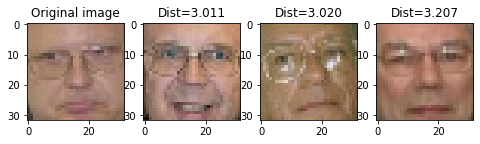

In [33]:
show_similar(X_test[63])

## 5. Cheap image morphing


Linear combinations of image codes can be taken to produce new images with the decoder.

In [34]:
#restore trained encoder weights
s = tf.keras.backend.clear_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

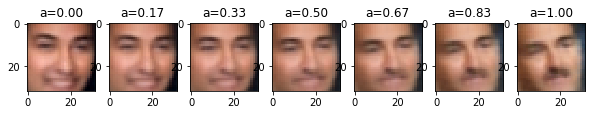

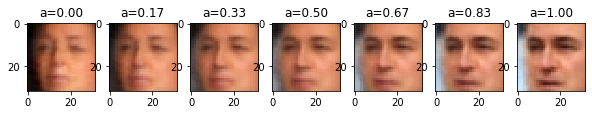

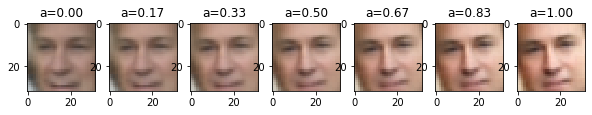

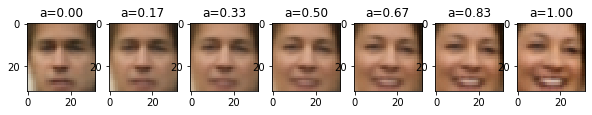

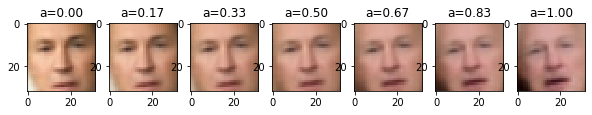

In [35]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()